# OLS on Basic Variable Set

In [21]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
from reed import *
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time
import statsmodels.api as sm
from direct_regression import plot_ate_distribution


# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.0'

#### Select modeling parameters

In [2]:
outcome = 'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False

config_name = "default"
data_file = "data/basic_variables.csv"
test = False

In [3]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 1000

### Load Data 
   - drop rows missing the specified treatment or outcome

In [4]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 284 rows missing treatment or outcome.


### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 21)
Treated data dimensions: (1368, 21)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:509.12±16.55
Average outcome under Treatment:852.67±27.99
Unadjusted treatment estimate 343.55


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [7]:
from sklearn.linear_model import LinearRegression
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

In [8]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Fitting OLS ...Done


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
OLS,-13.93,8.80,0.30,0.07,0.22,0.09,"-739,586.63","255,969.76","-845,845.11","296,081.87"


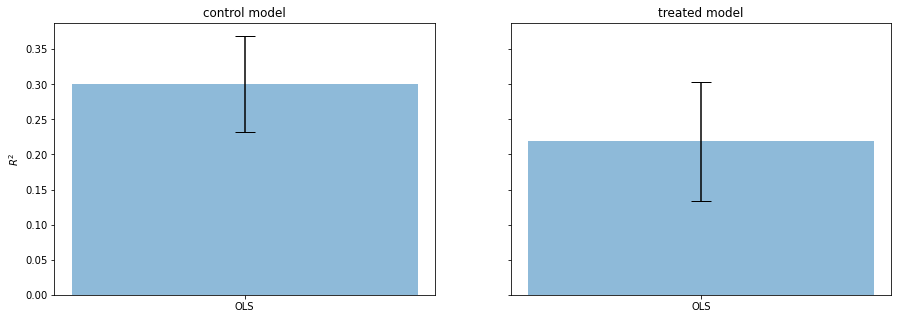

In [9]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models

In [10]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

OLS


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
"ahgage_(54, 120]",540.844315,9.548782,-64.745010,26.032824,-573.216820,17.460744,-508.471810,14.708326
"ahgage_(44, 54]",500.018145,6.282780,-19.405804,20.028767,-509.721047,9.971607,-490.315243,13.419741
aedhigh1_9.0,254.139803,18.951783,32.541309,33.554263,-237.869149,27.373284,-270.410458,23.064860
ahgsex_2.0,233.357958,14.514820,50.502121,41.766356,-208.106897,23.125959,-258.609018,27.545676
aesdtl_3.0,196.290695,8.671879,-135.083969,15.892921,-263.832680,14.808931,-128.748711,7.575684
"interact_ahgsex_2.0_ahgage_(54, 120]",158.673721,9.044330,-17.344595,20.605509,150.001424,16.190415,167.346019,10.666008
"interact_ahgsex_2.0_ahgage_(44, 54]",144.985077,5.357528,-22.990870,14.994694,133.489642,8.417576,156.480512,9.948419
aesdtl_2.0,131.495508,12.416407,-54.880409,25.409131,-158.935713,23.102164,-104.055304,9.870984
aedhigh1_8.0,124.952394,14.287997,45.760030,21.788275,-102.072379,22.207247,-147.832408,12.348941


### What are the major confounders

  - We want to identify variables that strongly effect both treatment and outcome
   
For each variable Z, in the covariate set lets compute $E[Z|T=1] - E[Z|T=0]$

In [11]:
Xt = np.hstack((t.reshape(-1,1),X))
model = LinearRegression()
model.fit(Xt,y)
beta = model.coef_[1:]

confound = pd.DataFrame({'response_coef':beta, 'treatment_inf':X1.mean(axis=0) - X0.mean(axis=0)},index=features)
confound['confound'] = np.abs(confound['response_coef'])*np.abs(confound['treatment_inf'])
confound.sort_values(by='confound',ascending=False)

,response_coef,treatment_inf,confound
"ahgage_(54, 120]",-512.494738,-0.574540,294.448748
aedhigh1_9.0,-248.128054,-0.283646,70.380458
"interact_ahgsex_2.0_ahgage_(54, 120]",150.241762,-0.405574,60.934087
"ahgage_(44, 54]",-497.443083,-0.116053,57.729775
aesdtl_3.0,-152.086215,-0.291709,44.364971
ahgsex_2.0,-236.069008,0.098549,23.264394
"ahgage_(34, 44]",-70.278291,0.252289,17.730473
interact_ahgsex_2.0_aedhigh1_9.0,67.481464,-0.162992,10.998941
aesdtl_2.0,-116.337233,0.091144,10.603442
interact_ahgsex_2.0_aesdtl_2.0,69.803041,0.135050,9.426870


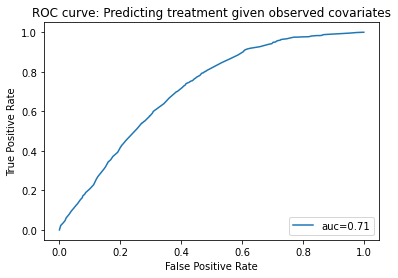

In [12]:
p_model = LogisticRegression()
p_model.fit(X,t)
p_model.coef_
p = p_model.predict_proba(X)[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(t,p)
fpr, tpr, _ = roc_curve(t,p)
plt.plot(fpr, tpr,label=f'auc={auc:.2f}')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: Predicting treatment given observed covariates");

In [13]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=False,
    samples=bootstrap_samples
)

Fitting OLS ...Done
Total time:3.183394193649292 seconds


####  Average treatment effect uncertainty via Bootstrapping

,ACE,ACE_std
OLS,-14.235132,27.565782


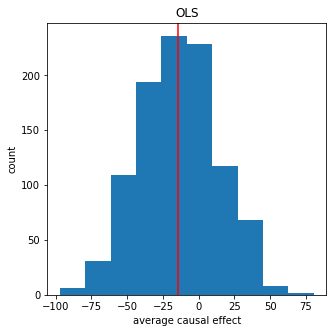

In [23]:
from direct_regression import compute_ate

metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
display(metrics)
plot_ate_distribution(tau_estimatesb)

## Statsmodels

Statsmodels provides a useful comparison, in that it is an independent implementation of OLS and provides theory based confidence intervals and p-values.

### Control Model

In [15]:
x0 = sm.add_constant(X0)
x0 = pd.DataFrame(x0, columns=['intercept']+features)
model0 = sm.OLS(y0,x0)
sm_result = model0.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     75.88
Date:                Fri, 19 Nov 2021   Prob (F-statistic):          3.12e-269
Time:                        13:59:45   Log-Likelihood:                -30952.
No. Observations:                3789   AIC:                         6.195e+04
Df Residuals:                    3767   BIC:                         6.209e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              592.6120     14.178     41.799      0.000     564.815     620.409
ahgage_(34, 44]                        -41.2745     28.378     -1.454      0.146     -96.913      14.364
ahgage_(44, 54]                       -490.1995     27.679    -17.710      0.000    -544.467    -435.932
ahgage_(54, 120]                      -508.3990     28.959    -17.556      0.000    -565.176    -451.622
ahgsex_2.0                            -258.7076     56.256     -4.599      0.000    -369.004    -148.412
aedhigh1_3.0                            -5.6776     28.387     -0.200      0.841     -61.334      49.978
aedhigh1_4.0                           -90.8251     26.601     -3.414      0.001    -142.978     -38.672
aedhigh1_5.0                          -136.2689     28.465     -4.787      0.000    -192.077     -80.461
aedhigh1_8.0                          -147.9562     29.748     -4.974      0.000    -206.279     -89.633
aedhigh1_9.0                          -270.6322     35.622     -7.597      0.000    -340.472    -200.793
aesdtl_2.0                            -104.1199     29.881     -3.485      0.000    -162.704     -45.536
aesdtl_3.0                            -128.8117     26.395     -4.880      0.000    -180.562     -77.061
interact_ahgsex_2.0_ahgage_(34, 44]    -15.1385     31.418     -0.482      0.630     -76.737      46.460
interact_ahgsex_2.0_ahgage_(44, 54]    156.3638     30.091      5.196      0.000      97.368     215.360
interact_ahgsex_2.0_ahgage_(54, 120]   167.2396     30.944      5.405      0.000     106.571     227.908
interact_ahgsex_2.0_aedhigh1_3.0        -7.9152     30.526     -0.259      0.795     -67.765      51.935
interact_ahgsex_2.0_aedhigh1_4.0        21.3748     28.126      0.760      0.447     -33.768      76.518
interact_ahgsex_2.0_aedhigh1_5.0         1.8726     26.245      0.071      0.943     -49.583      53.328
interact_ahgsex_2.0_aedhigh1_8.0        26.3906     33.312      0.792      0.428     -38.920      91.702
interact_ahgsex_2.0_aedhigh1_9.0        79.8192     45.171      1.767      0.077      -8.743     168.382
interact_ahgsex_2.0_aesdtl_2.0          50.8805     33.471      1.520      0.129     -14.743     116.504
interact_ahgsex_2.0_aesdtl_3.0           6.5603     31.789      0.206      0.837     -55.765      68.886
==============================================================================
Omnibus:                     3913.066   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525305.192
Skew:                           4.801   Prob(JB):                         0.00
Kurtosis:                      59.878   Cond. No.                         13.0
===============================================================

### Treated Model

In [16]:
x1 = sm.add_constant(X1)
x1 = pd.DataFrame(x1, columns=['intercept']+features)
model1 = sm.OLS(y1,x1)
sm_result = model1.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     19.48
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           2.00e-63
Time:                        13:59:45   Log-Likelihood:                -11257.
No. Observations:                1368   AIC:                         2.256e+04
Df Residuals:                    1346   BIC:                         2.267e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              578.7013     32.743     17.674      0.000     514.468     642.934
ahgage_(34, 44]                       -129.5504     41.172     -3.147      0.002    -210.319     -48.782
ahgage_(44, 54]                       -509.2432     45.344    -11.231      0.000    -598.195    -420.291
ahgage_(54, 120]                      -572.5443     71.688     -7.987      0.000    -713.176    -431.912
ahgsex_2.0                            -207.2179     76.112     -2.723      0.007    -356.530     -57.906
aedhigh1_3.0                            57.9908     45.224      1.282      0.200     -30.726     146.707
aedhigh1_4.0                           -14.6470     43.017     -0.340      0.734     -99.034      69.740
aedhigh1_5.0                           -43.6017     44.379     -0.982      0.326    -130.662      43.458
aedhigh1_8.0                          -101.7221     50.592     -2.011      0.045    -200.970      -2.475
aedhigh1_9.0                          -237.0608     62.718     -3.780      0.000    -360.096    -114.025
aesdtl_2.0                            -159.2217     61.624     -2.584      0.010    -280.111     -38.332
aesdtl_3.0                            -263.9733     59.472     -4.439      0.000    -380.642    -147.305
interact_ahgsex_2.0_ahgage_(34, 44]     30.0920     42.910      0.701      0.483     -54.086     114.270
interact_ahgsex_2.0_ahgage_(44, 54]    133.1317     47.777      2.787      0.005      39.407     226.856
interact_ahgsex_2.0_ahgage_(54, 120]   149.3189     76.852      1.943      0.052      -1.444     300.082
interact_ahgsex_2.0_aedhigh1_3.0       -42.9002     45.769     -0.937      0.349    -132.687      46.886
interact_ahgsex_2.0_aedhigh1_4.0       -34.1949     43.475     -0.787      0.432    -119.480      51.090
interact_ahgsex_2.0_aedhigh1_5.0       -41.0318     39.258     -1.045      0.296    -118.045      35.982
interact_ahgsex_2.0_aedhigh1_8.0        23.0010     52.698      0.436      0.663     -80.379     126.381
interact_ahgsex_2.0_aedhigh1_9.0        66.6311     73.328      0.909      0.364     -77.219     210.481
interact_ahgsex_2.0_aesdtl_2.0         122.6979     63.473      1.933      0.053      -1.818     247.214
interact_ahgsex_2.0_aesdtl_3.0         148.9535     63.538      2.344      0.019      24.310     273.597
==============================================================================
Omnibus:                      914.745   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34051.967
Skew:                           2.574   Prob(JB):                         0.00
Kurtosis:                      26.893   Cond. No.                         10.1
===============================================================

### Fully coupled model
Fit a single model for both treatment and control surfaces with a treatment indicator. 

```{note}
This assumes there is no treatment effect heterogeneity
```

In [17]:
x = np.hstack((t.reshape(-1,1),X))
x = sm.add_constant(x)
x = pd.DataFrame(x, columns=['intercept','treatment']+features)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     96.43
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:59:45   Log-Likelihood:                -42223.
No. Observations:                5157   AIC:                         8.449e+04
Df Residuals:                    5134   BIC:                         8.464e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              595.0536     14.386     41.364      0.000     566.851     623.256
treatment                               19.6004     29.075      0.674      0.500     -37.400      76.601
ahgage_(34, 44]                        -70.2783     23.120     -3.040      0.002    -115.603     -24.953
ahgage_(44, 54]                       -497.4431     23.197    -21.444      0.000    -542.920    -451.966
ahgage_(54, 120]                      -512.4947     25.458    -20.131      0.000    -562.404    -462.586
ahgsex_2.0                            -236.0690     44.610     -5.292      0.000    -323.524    -148.614
aedhigh1_3.0                            14.4562     23.806      0.607      0.544     -32.214      61.126
aedhigh1_4.0                           -68.1331     22.479     -3.031      0.002    -112.202     -24.065
aedhigh1_5.0                          -107.3494     23.738     -4.522      0.000    -153.887     -60.812
aedhigh1_8.0                          -131.7878     25.424     -5.184      0.000    -181.629     -81.946
aedhigh1_9.0                          -248.1281     30.367     -8.171      0.000    -307.661    -188.595
aesdtl_2.0                            -116.3372     26.878     -4.328      0.000    -169.029     -63.645
aesdtl_3.0                            -152.0862     24.103     -6.310      0.000    -199.338    -104.834
interact_ahgsex_2.0_ahgage_(34, 44]     -4.1814     25.006     -0.167      0.867     -53.205      44.842
interact_ahgsex_2.0_ahgage_(44, 54]    144.6705     24.777      5.839      0.000      96.097     193.245
interact_ahgsex_2.0_ahgage_(54, 120]   150.2418     26.513      5.667      0.000      98.264     202.219
interact_ahgsex_2.0_aedhigh1_3.0       -17.4109     25.133     -0.693      0.489     -66.683      31.861
interact_ahgsex_2.0_aedhigh1_4.0         6.4536     23.417      0.276      0.783     -39.453      52.360
interact_ahgsex_2.0_aedhigh1_5.0       -10.7115     21.643     -0.495      0.621     -53.141      31.718
interact_ahgsex_2.0_aedhigh1_8.0        25.9117     27.840      0.931      0.352     -28.667      80.490
interact_ahgsex_2.0_aedhigh1_9.0        67.4815     37.665      1.792      0.073      -6.358     141.321
interact_ahgsex_2.0_aesdtl_2.0          69.8030     29.337      2.379      0.017      12.289     127.317
interact_ahgsex_2.0_aesdtl_3.0          35.3401     28.093      1.258      0.208     -19.734      90.414
==============================================================================
Omnibus:                     4806.305   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           479097.779
Skew:                           4.132   Prob(JB):                         0.00
Kurtosis:                      49.490